# 🎯 Test Export - Analyse et export de frames SF6

Ce notebook traite un dossier de frames extraites Street Fighter 6 avec **ImageAnalyzer moderne** :

## ✅ **Fonctionnalités**
- **Chargement automatique** des ROIs depuis `rois_config.json` via RoiManager
- **Analyse OCR hybride** : TrOCR pour timer + EasyOCR pour personnages  
- **Images annotées** : Sauvegarde automatique avec détections visualisées
- **Export JSON structuré** : Tous les résultats dans un fichier JSON
- **Statistiques détaillées** : Taux de détection par ROI, progression en temps réel
- **Preprocessing configurable** : Utilisation de PreprocessingStep.NONE par défaut

## 🔧 **Architecture moderne**
- **RoiManager** : Chargement des ROIs depuis configuration centralisée
- **ImageAnalyzer** : OCR hybride avec sauvegarde automatique des images debug
- **API cohérente** : Même approche que `test-analyze.ipynb`

**⚠️ Prérequis :** ROIs configurées avec `ROIs_placer.ipynb` dans `rois_config.json`

**🚀 Équivalent moderne du script `test/test-export.py`**

In [1]:
import cv2 as cv
import numpy as np
import os
import json
import re
from datetime import datetime
import sys
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from pathlib import Path

# Add the project root to the Python path
project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.image_analyzer import ImageAnalyzer
from src.roi_manager import RoiManager
from src.preprocessing_steps import PreprocessingStep

print("✅ Imports terminés - Test Export avec ImageAnalyzer + RoiManager")
print("🔧 Configuration: ImageAnalyzer avec OCR hybride")
print("📋 Utilisation de RoiManager pour charger les ROIs")

✅ Imports terminés - Test Export avec ImageAnalyzer + RoiManager
🔧 Configuration: ImageAnalyzer avec OCR hybride
📋 Utilisation de RoiManager pour charger les ROIs


## Configuration

In [2]:
# Configuration
FRAMES_FOLDER_PATH = '../../input/frames/'  # Changez ce chemin selon votre dossier de frames
OUTPUT_DIRECTORY = '../../output/analyzed_frames'  # Standardisé
RESULTS_JSON_FILENAME = 'test_results.json'

print(f"Dossier de frames: {FRAMES_FOLDER_PATH}")
print(f"Dossier de sortie: {OUTPUT_DIRECTORY}")
print(f"Fichier JSON de résultats: {RESULTS_JSON_FILENAME}")

Dossier de frames: ../../input/frames/
Dossier de sortie: ../../output/analyzed_frames
Fichier JSON de résultats: test_results.json


## Vérification de l'existence du dossier

In [3]:
if not os.path.exists(FRAMES_FOLDER_PATH):
    print(f"❌ Erreur: Le dossier '{FRAMES_FOLDER_PATH}' n'existe pas.")
    
    # Suggérer des alternatives
    input_dir = 'input'
    if os.path.exists(input_dir):
        subdirs = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
        if subdirs:
            print(f"Dossiers disponibles dans {input_dir}:")
            for subdir in subdirs:
                print(f"  - {subdir}")
else:
    print(f"✅ Dossier trouvé: {FRAMES_FOLDER_PATH}")
    
    # Vérifier la structure : sous-dossiers + images dans chaque sous-dossier
    subdirs = [d for d in os.listdir(FRAMES_FOLDER_PATH) if os.path.isdir(os.path.join(FRAMES_FOLDER_PATH, d))]
    
    if subdirs:
        print(f"📁 {len(subdirs)} sous-dossiers trouvés (un par vidéo):")
        
        total_images = 0
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
        
        for subdir in subdirs[:5]:  # Afficher max 5 premiers
            subdir_path = os.path.join(FRAMES_FOLDER_PATH, subdir)
            image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(image_extensions)]
            total_images += len(image_files)
            print(f"  - {subdir}: {len(image_files)} images")
            
        if len(subdirs) > 5:
            # Compter les images dans les dossiers restants
            for subdir in subdirs[5:]:
                subdir_path = os.path.join(FRAMES_FOLDER_PATH, subdir)
                image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(image_extensions)]
                total_images += len(image_files)
            print(f"  ... et {len(subdirs) - 5} autres dossiers")
            
        print(f"📊 Total: {total_images} images dans {len(subdirs)} dossiers")
        
    else:
        # Vérifier les images directement dans le dossier racine (ancien comportement)
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
        image_files = [f for f in os.listdir(FRAMES_FOLDER_PATH) if f.lower().endswith(image_extensions)]
        
        print(f"📊 {len(image_files)} images trouvées directement dans le dossier")
        if image_files:
            print("Exemples d'images:")
            for img in image_files[:5]:
                print(f"  - {img}")
            if len(image_files) > 5:
                print(f"  ... et {len(image_files) - 5} autres")
        else:
            print("⚠️  Aucune image ni sous-dossier trouvé")

✅ Dossier trouvé: ../../input/frames/
📁 1 sous-dossiers trouvés (un par vidéo):
  - match: 588 images
📊 Total: 588 images dans 1 dossiers


## Fonction de traitement des frames

In [8]:
import contextlib
import io

def process_street_fighter_frames_for_data_extraction(frames_folder_path):
    """
    Traite un dossier de frames Street Fighter 6 pour extraction de données avec ImageAnalyzer moderne.
    Support des sous-dossiers (un par vidéo) et images directement dans le dossier racine.
    """
    if not os.path.exists(frames_folder_path):
        print(f"❌ Erreur: Le dossier '{frames_folder_path}' n'existe pas.")
        return

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)

    print("📂 Chargement des ROIs avec RoiManager...")
    try:
        roi_manager = RoiManager('../../rois_config.json')
        roi_manager.load()
        
        print("✅ ROIs chargées avec succès")
        print(roi_manager.get_roi_info_summary())
        
        roi_configs = roi_manager.to_image_analyzer_format()
        timer_roi = roi_configs.get('timer')
        character1_roi = roi_configs.get('character1')
        character2_roi = roi_configs.get('character2')
        
        analyzer = ImageAnalyzer(
            timer_roi=timer_roi,
            character1_roi=character1_roi,
            character2_roi=character2_roi,
            config_file='../../rois_config.json',
            characters_file='../../characters.json',
            debug=True,
            debug_save_dir=OUTPUT_DIRECTORY
        )
        
        print("✅ ImageAnalyzer configuré avec OCR hybride (logs muets pendant traitement)")
        
    except Exception as e:
        print(f"❌ Erreur lors de l'initialisation: {e}")
        print("💡 Assurez-vous que rois_config.json est configuré avec ROIs_placer.ipynb")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    all_image_paths = []
    
    subdirs = [d for d in os.listdir(frames_folder_path) if os.path.isdir(os.path.join(frames_folder_path, d))]
    
    if subdirs:
        print(f"📁 Structure avec sous-dossiers détectée ({len(subdirs)} dossiers)")
        
        for subdir in subdirs:
            subdir_path = os.path.join(frames_folder_path, subdir)
            subdir_images = []
            
            for file in os.listdir(subdir_path):
                if file.lower().endswith(image_extensions):
                    full_path = os.path.join(subdir_path, file)
                    all_image_paths.append({
                        'path': full_path,
                        'filename': file,
                        'video_folder': subdir,
                        'relative_path': os.path.join(subdir, file)
                    })
                    subdir_images.append(file)
            
            if subdir_images:
                print(f"  - {subdir}: {len(subdir_images)} images")
        
        all_image_paths.sort(key=lambda x: (x['video_folder'], x['filename']))
        
    else:
        print("📁 Images directement dans le dossier racine")
        
        for file in os.listdir(frames_folder_path):
            if file.lower().endswith(image_extensions):
                full_path = os.path.join(frames_folder_path, file)
                all_image_paths.append({
                    'path': full_path,
                    'filename': file,
                    'video_folder': None,
                    'relative_path': file
                })
        
        all_image_paths.sort(key=lambda x: x['filename'])
    
    if not all_image_paths:
        print(f"❌ Aucune image trouvée dans le dossier '{frames_folder_path}'.")
        return

    json_results_file_path = os.path.join(OUTPUT_DIRECTORY, RESULTS_JSON_FILENAME)
    results_data = []
    
    print(f"\n🚀 Analyse de {len(all_image_paths)} images avec OCR hybride")
    print(f"📁 Dossier source: {frames_folder_path}")
    print(f"💾 Résultats dans: {OUTPUT_DIRECTORY}")
    print(f"🔧 Preprocessing: NONE (image brute)")
    print(f"🖼️  Images debug sauvegardées (mode silencieux)")
    print("\n🔄 Progression:")

    successful_analyses = 0
    failed_analyses = 0

    for i, image_info in enumerate(all_image_paths):
        image_path = image_info['path']
        image_filename = image_info['filename']
        video_folder = image_info['video_folder']
        relative_path = image_info['relative_path']
        
        timestamp_match = re.search(r'(\d{2})-(\d{2})-(\d{2})', image_filename)
        if timestamp_match:
            hours, minutes, seconds = timestamp_match.groups()
            formatted_timestamp = f"{hours}:{minutes}:{seconds}"
        else:
            formatted_timestamp = f"00:{i//60:02d}:{i%60:02d}"
        
        current_frame = cv.imread(image_path)
        if current_frame is None:
            failed_analyses += 1
            continue
            
        try:
            with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                results = analyzer.analyze_frame(
                    current_frame,
                    rois_to_analyze=['timer', 'character1', 'character2'],
                    preprocessing=PreprocessingStep.NONE
                )

            frame_data = {
                "timestamp": formatted_timestamp,
                "filename": image_filename,
                "relative_path": relative_path,
                "video_folder": video_folder,
                "timer_value": results.get('timer', ''),
                "character1": results.get('character1', ''),
                "character2": results.get('character2', ''),
                "preprocessing": str(PreprocessingStep.NONE)
            }
            results_data.append(frame_data)
            successful_analyses += 1
            
        except Exception as e:
            failed_analyses += 1

        if (i + 1) % 10 == 0 or (i + 1) == len(all_image_paths):
            progress = ((i + 1) / len(all_image_paths)) * 100
            bar_width = 40
            filled = int(bar_width * (i + 1) / len(all_image_paths))
            bar = "█" * filled + "░" * (bar_width - filled)
            print(f"\r[{bar}] {progress:5.1f}% ({i + 1:4d}/{len(all_image_paths)}) - ✅{successful_analyses:4d} ❌{failed_analyses:3d}", end="", flush=True)
            
            if (i + 1) == len(all_image_paths):
                print()

    with open(json_results_file_path, 'w', encoding='utf-8') as json_file:
        json.dump(results_data, json_file, indent=2, ensure_ascii=False)
    
    print(f"\n" + "=" * 60)
    print(f"✅ ANALYSE TERMINÉE!")
    print(f"   Images traitées: {len(all_image_paths)}")
    print(f"   Succès: {successful_analyses}")
    print(f"   Échecs: {failed_analyses}")
    print(f"   Taux de succès: {successful_analyses/len(all_image_paths)*100:.1f}%")
    print(f"\n💾 Résultats JSON: {json_results_file_path}")
    print(f"🖼️  Images annotées: {OUTPUT_DIRECTORY}")
    
    if successful_analyses > 0:
        timer_detections = sum(1 for r in results_data if r['timer_value'])
        char1_detections = sum(1 for r in results_data if r['character1'])
        char2_detections = sum(1 for r in results_data if r['character2'])
        
        print(f"\n🎯 Détections par ROI:")
        print(f"   Timer: {timer_detections}/{successful_analyses} ({timer_detections/successful_analyses*100:.1f}%)")
        print(f"   Character1: {char1_detections}/{successful_analyses} ({char1_detections/successful_analyses*100:.1f}%)")
        print(f"   Character2: {char2_detections}/{successful_analyses} ({char2_detections/successful_analyses*100:.1f}%)")
    
    return results_data, json_results_file_path

## Exécution du traitement

In [5]:
if os.path.exists(FRAMES_FOLDER_PATH):
    print(f"🎯 Analyse du dossier: {FRAMES_FOLDER_PATH}")
    
    try:
        results_data, json_file_path = process_street_fighter_frames_for_data_extraction(FRAMES_FOLDER_PATH)
        
        if results_data:
            print("\n🎉 Export terminé avec succès!")
            print(f"📄 Fichier JSON généré: {json_file_path}")
            print(f"📊 {len(results_data)} frames analysées et exportées")
                
    except Exception as e:
        print(f"❌ Erreur lors du traitement: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print(f"❌ Impossible de traiter - le dossier {FRAMES_FOLDER_PATH} n'existe pas")

🎯 Analyse du dossier: ../../input/frames/
📂 Chargement des ROIs avec RoiManager...
✅ ROIs chargées avec succès
Configuration: ../../rois_config.json
ROIs disponibles: 3
  - TIMER (timer): 0.460,0.040 → 0.540,0.180 [ocr]
  - PLAYER 1 (character1): 0.000,0.020 → 0.100,0.150 [ocr]
  - PLAYER 2 (character2): 0.900,0.019 → 1.000,0.150 [ocr]
[ImageAnalyzer] ✅ Loaded 26 character names from ../../characters.json
[ImageAnalyzer] ✅ Loaded 3 ROI configurations from ../../rois_config.json: timer, character1, character2
[ImageAnalyzer] 🔄 Chargement de TrOCR...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using CPU. Note: This module is much faster with a GPU.


[ImageAnalyzer] ✅ TrOCR chargé avec succès
[ImageAnalyzer] 🔄 Chargement de EasyOCR...
[ImageAnalyzer] ✅ EasyOCR chargé avec succès
[ImageAnalyzer] Statut OCR - TrOCR: ✅, EasyOCR: ✅
✅ ImageAnalyzer configuré avec OCR hybride (logs muets pendant traitement)
📁 Structure avec sous-dossiers détectée (1 dossiers)
  - match: 588 images

🚀 Analyse de 588 images avec OCR hybride
📁 Dossier source: ../../input/frames/
💾 Résultats dans: ../../output/analyzed_frames
🔧 Preprocessing: NONE (image brute)
🖼️  Images debug sauvegardées (mode silencieux)

🔄 Progression:
[████████████████████████████████████████] 100.0% ( 588/588) - ✅ 588 ❌  0

✅ ANALYSE TERMINÉE!
   Images traitées: 588
   Succès: 588
   Échecs: 0
   Taux de succès: 100.0%

💾 Résultats JSON: ../../output/analyzed_frames/test_results.json
🖼️  Images annotées: ../../output/analyzed_frames

🎯 Détections par ROI:
   Timer: 531/588 (90.3%)
   Character1: 429/588 (73.0%)
   Character2: 420/588 (71.4%)

🎉 Export terminé avec succès!
📄 Fichier J

## Affichage des résultats JSON (optionnel)

In [6]:
# Optionnel: afficher le contenu du fichier JSON généré
json_results_file_path = os.path.join(OUTPUT_DIRECTORY, RESULTS_JSON_FILENAME)

if os.path.exists(json_results_file_path):
    print(f"Contenu de {json_results_file_path}:")
    
    try:
        with open(json_results_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Afficher le JSON de manière formatée (limité aux premiers éléments)
        preview_data = data[:3] if len(data) > 3 else data
        print(json.dumps(preview_data, indent=2, ensure_ascii=False))
        
        if len(data) > 3:
            print(f"\n... et {len(data) - 3} autres entrées")
            
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier JSON: {str(e)}")
else:
    print(f"❌ Fichier JSON non trouvé: {json_results_file_path}")

Contenu de ../../output/analyzed_frames/test_results.json:
[
  {
    "timestamp": "00:00:00",
    "filename": "frame_00-00-00.png",
    "relative_path": "match/frame_00-00-00.png",
    "video_folder": "match",
    "timer_value": "14",
    "character1": "",
    "character2": "",
    "preprocessing": "NONE"
  },
  {
    "timestamp": "00:00:05",
    "filename": "frame_00-00-05.png",
    "relative_path": "match/frame_00-00-05.png",
    "video_folder": "match",
    "timer_value": "14",
    "character1": "",
    "character2": "",
    "preprocessing": "NONE"
  },
  {
    "timestamp": "00:00:10",
    "filename": "frame_00-00-10.png",
    "relative_path": "match/frame_00-00-10.png",
    "video_folder": "match",
    "timer_value": "14",
    "character1": "",
    "character2": "",
    "preprocessing": "NONE"
  }
]

... et 585 autres entrées


## Visualisation des résultats (optionnel)

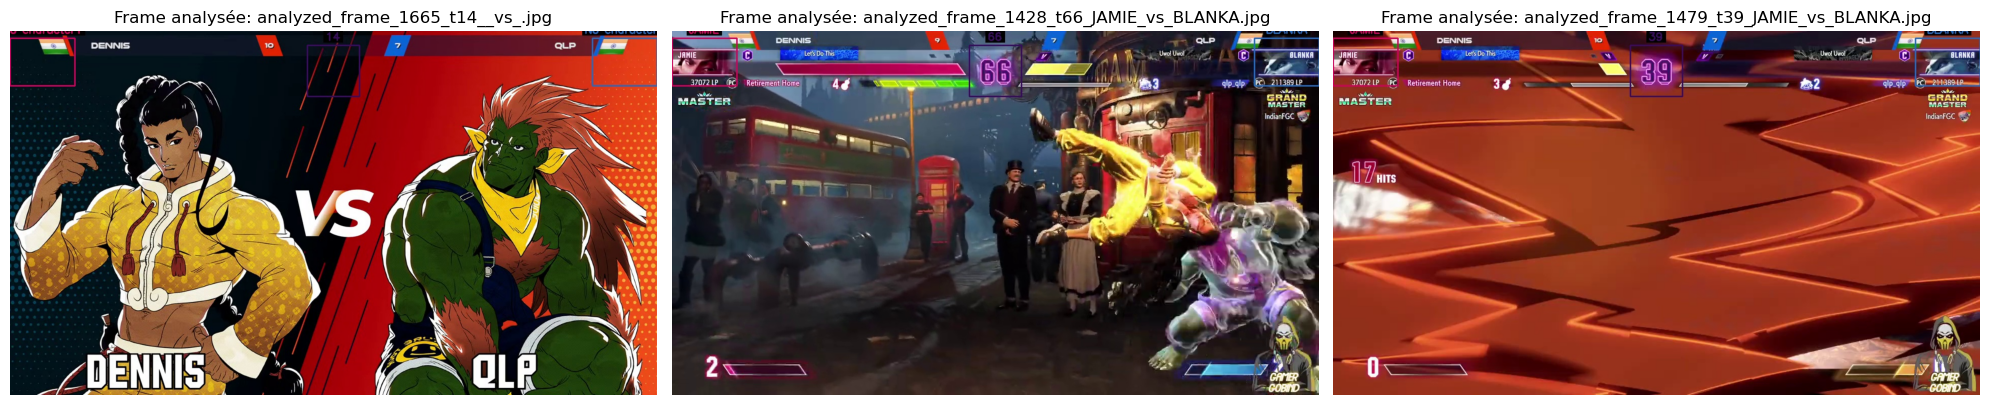

Affichage de 3 images sur 588 disponibles


In [7]:
# Optionnel: Visualiser quelques images analysées
analyzed_frames_output_folder = OUTPUT_DIRECTORY

if os.path.exists(analyzed_frames_output_folder):
    analyzed_images = [f for f in os.listdir(analyzed_frames_output_folder) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if analyzed_images:
        # Afficher les 3 premières images analysées
        num_to_show = min(3, len(analyzed_images))
        
        fig, axes = plt.subplots(1, num_to_show, figsize=(20, 8))
        if num_to_show == 1:
            axes = [axes]  # Assurer la cohérence pour une seule image
            
        for i in range(num_to_show):
            img_path = os.path.join(analyzed_frames_output_folder, analyzed_images[i])
            img = cv.imread(img_path)
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            
            axes[i].imshow(img_rgb)
            axes[i].set_title(f'Frame analysée: {analyzed_images[i]}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Affichage de {num_to_show} images sur {len(analyzed_images)} disponibles")
    else:
        print("❌ Aucune image analysée trouvée")
else:
    print(f"❌ Dossier d'images analysées non trouvé: {analyzed_frames_output_folder}")